In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sns.set(style="whitegrid")
BASE_PATH = Path("../cache_new/optimization/")

In [120]:
def prepare_data():
    csv_files = list(BASE_PATH.rglob("*df_reduced.csv"))
    dataframes = []

    for file in csv_files:
        df = pd.read_csv(file)
        parts = file.parts[-6:]
        
        match_id = parts[0]
        step = parts[2]
        player = parts[1]
        method = parts[3]
        parameters = parts[4]

        df["game_id"] = match_id
        df["step"] = step
        df["player"] = player
        df["method"] = method
        df["parameters"] = parameters
        df["tuning"] = method + "-" + parameters

        dataframes.append(df)

    full_df = pd.concat(dataframes, ignore_index=True)
    full_df["DAS_potential_percentage"] = np.where(
        full_df["DAS_potential"] > 0,
        ((full_df["DAS"] - full_df["DAS_new"]) / full_df["DAS"]) * 100,
        0.0,
    )

    return full_df

def group_data(full_df):
    grouped_df = (
        full_df.groupby(["game_id", "player", "step", "method", "parameters", "tuning"]).agg(
            DAS_potential=("DAS_potential", "mean"),
            DAS_potential_percentage=("DAS_potential_percentage", "mean"),
            distance=("distance", "mean"),
            count=("DAS_potential", "count")
        )
        .reset_index()
    )
    return grouped_df

def compare_methods(fair_grouped_df):
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential_percentage",
                ax=axes[0]
    )
    axes[0].set_title("Boxplot DAS-Potential (%)")
    axes[0].set_ylabel("Verbesserung (%)")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="DAS_potential",
                ax=axes[1]
    )
    axes[1].set_title("Boxplot DAS-Potential")
    axes[1].set_ylabel("Verbesserung")
    axes[1].set_xlabel("")
    axes[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)
    
    sns.boxplot(data=fair_grouped_df,
                x="tuning",
                y="distance",
                ax=axes[2]
    )
    axes[2].set_title("Boxplot Distance")
    axes[2].set_ylabel("Verbesserung")
    axes[2].tick_params(axis="x", rotation=45)
    
    fig.suptitle("Vergleich der Methoden", fontsize=16)
    fig.tight_layout()
    plt.show()

def bar_players(grouped_df):
    top_players = grouped_df.sort_values("DAS_potential_percentage", ascending=False).head(15)
    plt.figure(figsize=(12,6))
    sns.barplot(data=top_players, x="player", y="DAS_potential_percentage", hue="method")
    plt.title("Top 15 Spieler - Verbesserungspotenzial (%)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
def scatter_dist_pot(grouped_df):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x="distance", y="DAS_potential_percentage", hue="method")
    plt.title("Zusammenhang: Entfernung vs. Potential")
    plt.xlabel("Entfernung (m)")
    plt.ylabel("DAS_potential_percentage (%)")
    plt.tight_layout()
    plt.show()
    
def facet_grid(grouped_df):
    g = sns.FacetGrid(
        data=grouped_df,
        col="game_id",
        hue="method",
        sharey=True,
        height=4,
        aspect=1.5
    )
    g.map(sns.barplot, "player", "DAS_potential_percentage", order=sorted(grouped_df["player"].unique()), errorbar=None)
    g.add_legend()
    g.set_titles(col_template="Match: {col_name}")
    g.set_axis_labels("Spieler", "Verbesserung (%)")
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45)
        
    plt.tight_layout()
    plt.show()
    

In [117]:
full_df = prepare_data()
full_df.to_csv("output/full_das.csv", index=False)
grouped_df = group_data(full_df)
grouped_df.to_csv("output/grouped_das.csv", index=False)

# display("Values By Step")
# display(full_df["step"].value_counts())
# => Aktuell nur 125 Ergebnisse

# display("Values By Game")
# display(full_df.value_counts(["game_id", "player", "tuning"]))



In [118]:
# Übersicht vorhandene databallpy_event
pivot = full_df.groupby(["game_id", "tuning"])["player"].nunique().unstack(fill_value=0).reset_index()

pivot

tuning,game_id,all_positions-R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_20,random-R_5-S_1-D_2-N_50
0,J03WOH,1,32,1
1,J03WOY,1,32,1
2,J03WPY,1,31,1
3,J03WQQ,1,31,1
4,J03WR9,1,30,1


Anzahl verschiedener Parameterkombinationen: 3


'Vollständige Kombinationen: 5'

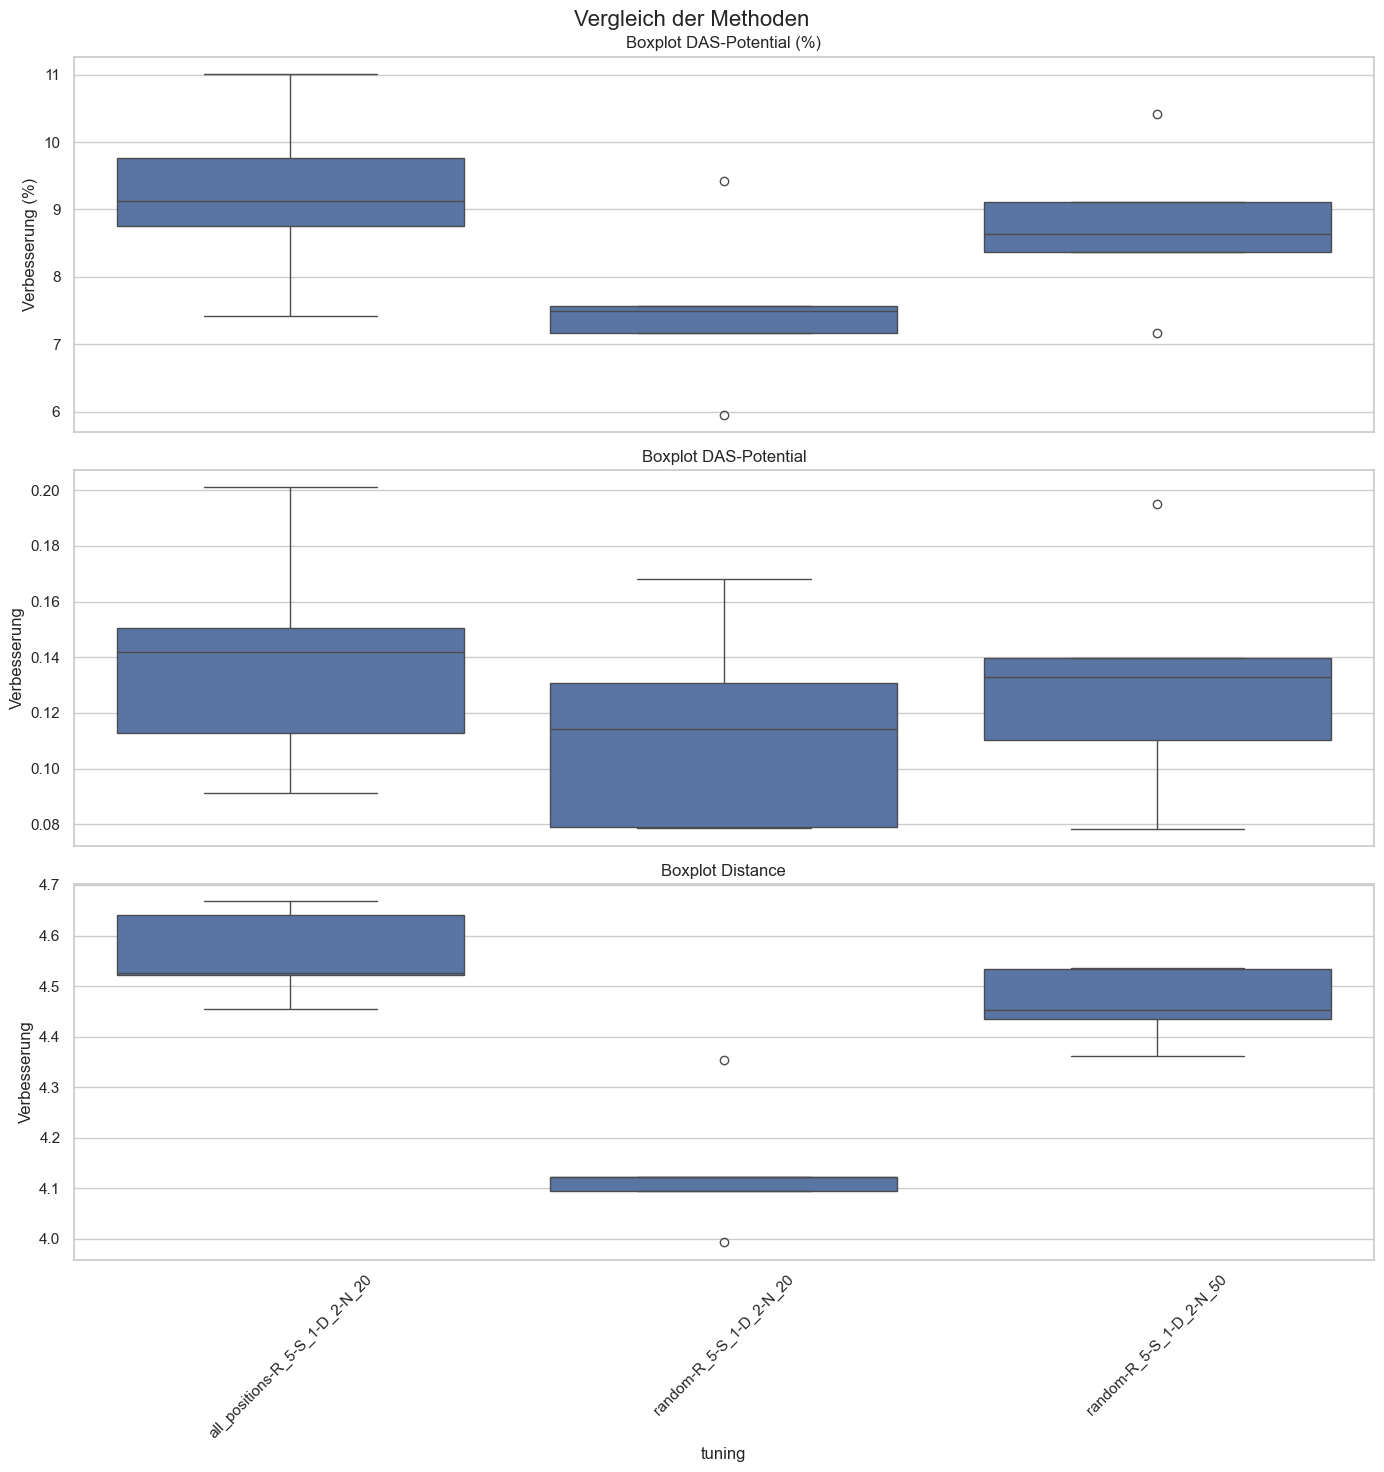

In [121]:
# Fairer Vergleich Methoden / Parameter
n_total_params = grouped_df["tuning"].nunique()
print(f"Anzahl verschiedener Parameterkombinationen: {n_total_params}")

param_counts = (
    grouped_df.groupby(["game_id", "player"])["tuning"]
    .nunique()
    .reset_index(name="param_count")
)
complete_combinations = param_counts[param_counts["param_count"] == n_total_params]
display(f"Vollständige Kombinationen: {len(complete_combinations)}")

fair_grouped_df = grouped_df.merge(complete_combinations, on=["game_id", "player"])

compare_methods(fair_grouped_df)



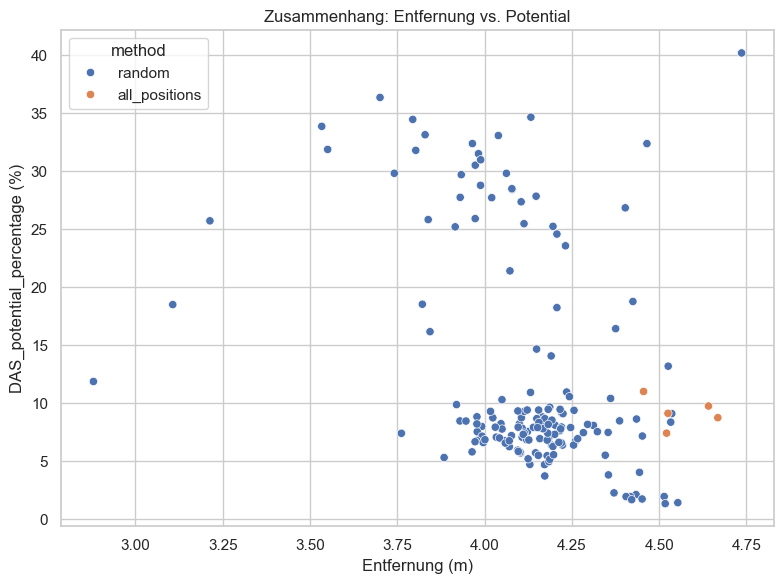

In [124]:
scatter_dist_pot(grouped_df)



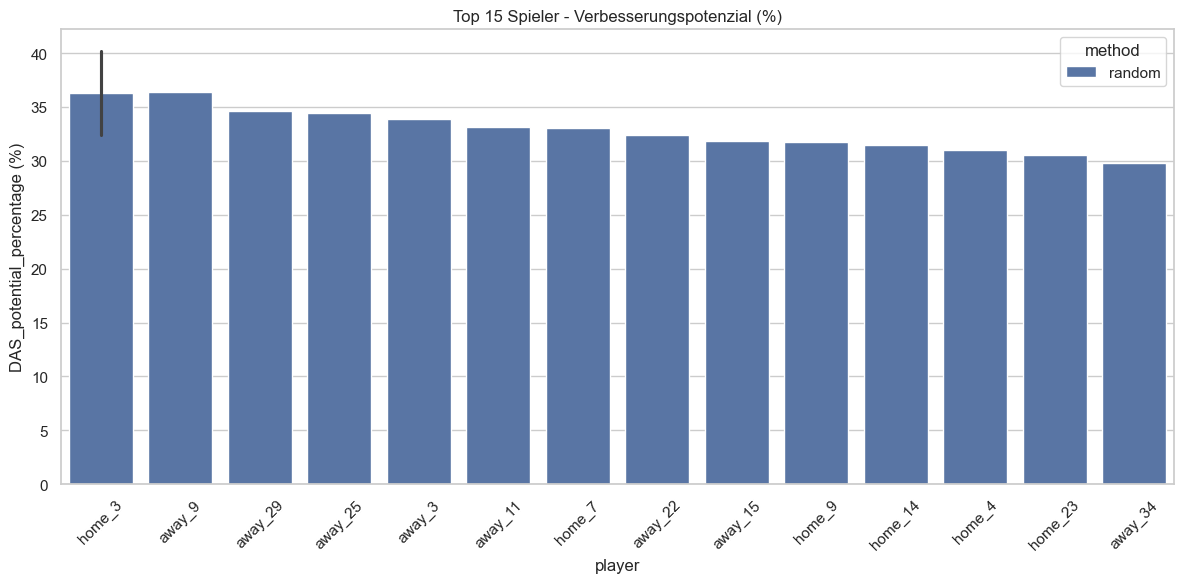

In [125]:
bar_players(grouped_df)